# Sometimes we observe weird non-exponential behavior in the iqid histograms
- this could be due to missed frames during the acquisition
- potentially fixable with offset file missed frame tracking
- greatly improves dropped frames in later parts of the acquisition
- does not seem to manage the "warm-up" time at the start of the acquisition

In [1]:
cd ..

C:\Users\Robin\Documents\Cal\iQID\git_branches\iqid-alphas


In [2]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt

from scipy.optimize import curve_fit

from tqdm import trange

%load_ext autoreload
%autoreload 2
from iqid import helper as iq
from iqid import process_object as po

pltmap = iq.set_plot_parms()

In [3]:
fmax = 2160000
fps = 25

datdir = r"D:\iQID\24-05xx-Ac225_Spheroids\22rV1_96H_UPTAKE\Listmode"
offname = glob.glob(os.path.join(datdir, "*Offsets_Full_Raw_Listmode.dat"))[0]
fname = glob.glob(os.path.join(datdir, "*Compressed_Processed_Listmode.dat"))[0]

In [4]:
offset_data = po.ClusterData(os.path.join(datdir, offname), ftype="offset_lm")
lm_data = po.ClusterData(os.path.join(datdir, fname), ftype="processed_lm")
time_ms, cluster_area, xC, yC, f_lm = lm_data.init_metadata(lm_data.load_cluster_data())
f_of, t, m, n, px, kelv = offset_data.init_metadata(offset_data.load_cluster_data(dtype=np.int32))

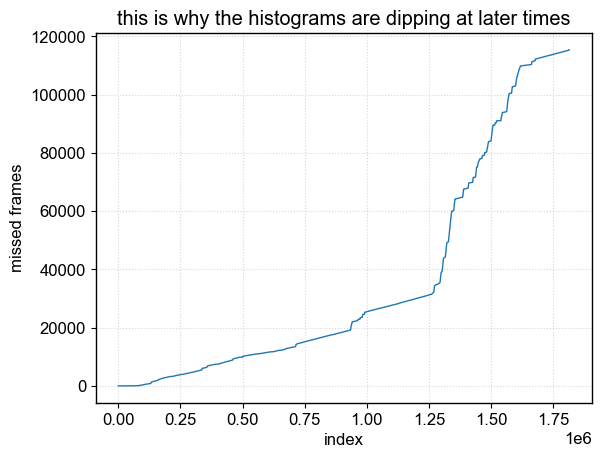

In [5]:
plt.plot(m)
plt.xlabel('index')
plt.ylabel('missed frames')
plt.title('this is why the histograms are dipping at later times')
plt.show()

In [6]:
corr_lm = lm_data.correct_listmode(f_of, m, vis=False)

Assigning missed frames: 100%|██████████████████████████████████████████▉| 6213340/6213591 [00:07<00:00, 864964.02it/s]


aborting : list-mode data contains higher frames than offset file. Remainder will be filled with previous m-values


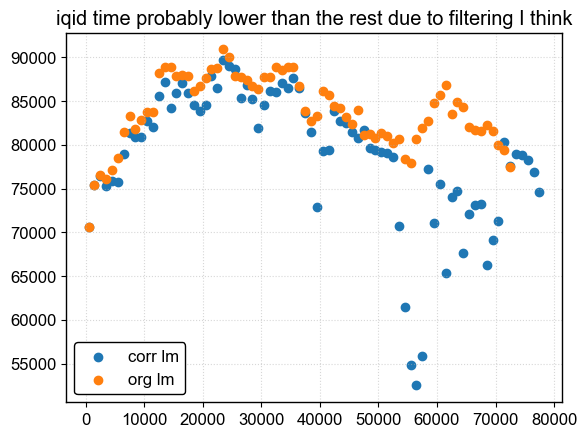

In [7]:
time_binsize=1000

test = corr_lm * 1 / fps
nbins = np.round(test[-1]/time_binsize)
count, bins = np.histogram(test, np.arange(0, nbins)*time_binsize)
ts = bins[:-1] + time_binsize/2
plt.scatter(ts, count, label='corr lm')

test = f_lm * 1 / fps
nbins = np.round(test[-1]/time_binsize)
count, bins = np.histogram(test, np.arange(0, nbins)*time_binsize)
ts = bins[:-1] + time_binsize/2
plt.scatter(ts, count, label='org lm')


plt.title("iqid time probably lower than the rest due to filtering I think")
plt.legend()

plt.show()

In [8]:
num_new_missed = np.diff(m)
missed_events_time_est = np.array([])
for i in trange(len(num_new_missed)):
    if num_new_missed[i] > 0:
        missed_events_time_est = np.append(missed_events_time_est,
                                           np.repeat(t[i], num_new_missed[i]))

100%|████████████████████████████████████████████████████████████████████| 1814510/1814510 [00:03<00:00, 603188.83it/s]


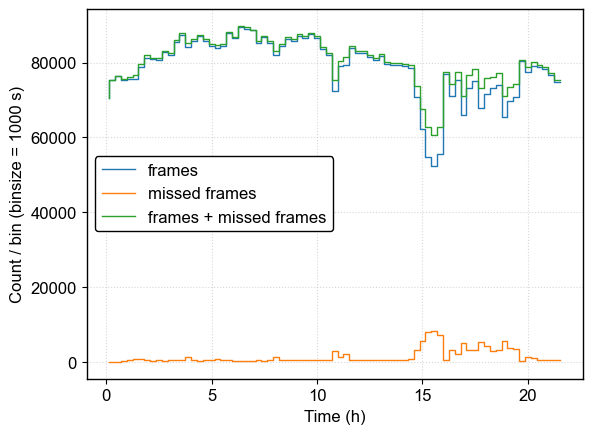

In [9]:
time_binsize = 1000

org_ts = time_ms / 1e3
nbins = np.round(org_ts[-1]/time_binsize)
count, bins = np.histogram(org_ts, np.arange(0, nbins)*time_binsize)
binned_m, _ = np.histogram(missed_events_time_est / 1e3, bins=bins)

ts = bins[:-1] + time_binsize/2
plt.step(ts / 3600, count, label='frames')
plt.step(ts / 3600, binned_m, label='missed frames')
plt.step(ts / 3600, count + binned_m, label='frames + missed frames')

plt.xlabel("Time (h)")
plt.ylabel("Count / bin (binsize = {:d} s)".format(time_binsize))

plt.legend()
plt.show()

### This won't quite capture all events, because most frames (including those missed) had > 1 event in them
- get the average # events per frame and include it

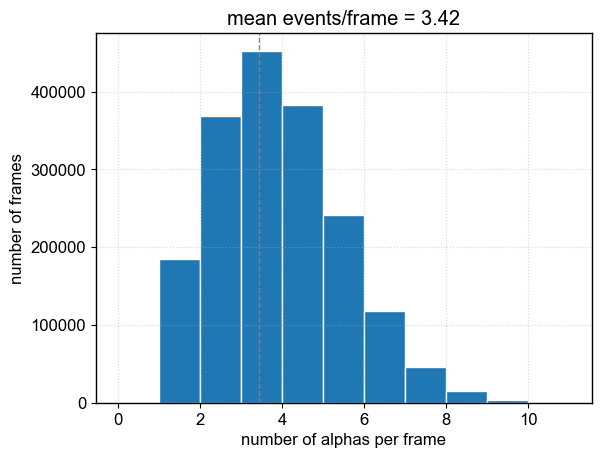

In [10]:
hist_N, _, _ = plt.hist(n, bins=np.arange(12), edgecolor='white')
plt.xlabel('number of alphas per frame')
plt.ylabel('number of frames')
plt.axvline(np.mean(n), color='gray', ls='--')
plt.title('mean events/frame = {:.2f}'.format(np.mean(n)))
plt.show()

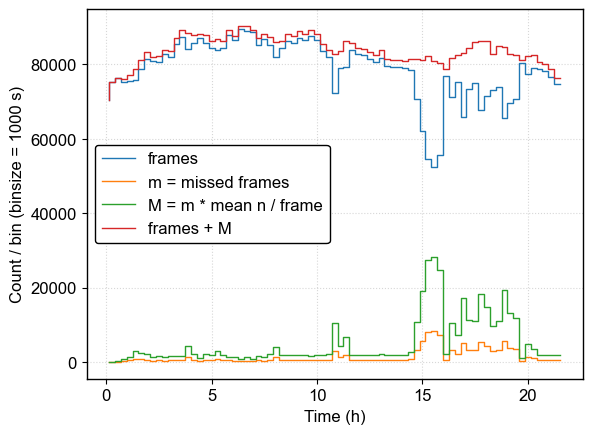

In [11]:
mult_binned_m = binned_m * np.mean(n)

ts = bins[:-1] + time_binsize/2
plt.step(ts / 3600, count, label='frames')
plt.step(ts / 3600, binned_m, label='m = missed frames')
plt.step(ts / 3600, mult_binned_m, label='M = m * mean n / frame')
plt.step(ts / 3600, count + mult_binned_m, label='frames + M')

plt.xlabel("Time (h)")
plt.ylabel("Count / bin (binsize = {:d} s)".format(time_binsize))

plt.legend()
plt.show()

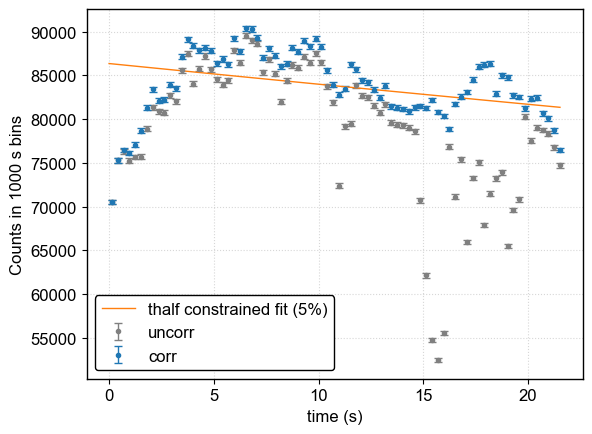

In [12]:
t_half_life = 9.92 * 24 * 3600 # updated value (2019) from NNDC for Ac-225

th = ts / 3600
corr_count = count + mult_binned_m

thalf = t_half_life / 3600
p0 = [150000, thalf]

tol = 0.05
popt, pcov = curve_fit(f=po.exponential, xdata=th, ydata=corr_count, p0=p0,
                       bounds=([0, thalf * (1-tol)], [np.inf, thalf * (1 + tol)]))
xdummy = np.linspace(0, max(th))
plt.errorbar(th, count, np.sqrt(count), ls='none', capsize=3, marker='.', label='uncorr', color='gray')
plt.errorbar(th, corr_count, np.sqrt(count), ls='none', capsize=3, marker='.', label='corr')
plt.plot(xdummy, po.exponential(xdummy, *popt), label='thalf constrained fit (5%)')

popt, pcov = curve_fit(f=po.exponential, xdata=th, ydata=corr_count, p0=p0,
                      bounds=([0,np.inf]))

plt.xlabel('time (s)')
plt.ylabel('Counts in {} s bins'.format(time_binsize))

plt.legend()
plt.show()

# Notes
- this only will really work for a single-ROI image
- because once we are looking at individual ROIs, we don't have a way to connect where in space each missed event is
- can only do it on average over whole acquisition
- see functions written in iqid.po for get_mean_n and estimate_missed_timestamps

# Same result, but obtained cleanly with the functions in the package

In [13]:
offset_data = po.ClusterData(os.path.join(datdir, offname), ftype="offset_lm")
lm_data = po.ClusterData(os.path.join(datdir, fname), ftype="processed_lm")
time_ms, cluster_area, xC, yC, f_lm = lm_data.init_metadata(lm_data.load_cluster_data())
f_of, t, m, n, px, kelv = offset_data.init_metadata(offset_data.load_cluster_data(dtype=np.int32))

In [14]:
missed_events_time = offset_data.estimate_missed_timestamps()

In [15]:
time_binsize = 1000
org_ts = time_ms / 1e3
nbins = np.round(org_ts[-1]/time_binsize)
count, bins = np.histogram(org_ts, np.arange(0, nbins)*time_binsize)

binned_m, _ = np.histogram(missed_events_time / 1e3, bins=bins)
m_correction = binned_m * offset_data.get_mean_n()
corr_count = count + m_correction

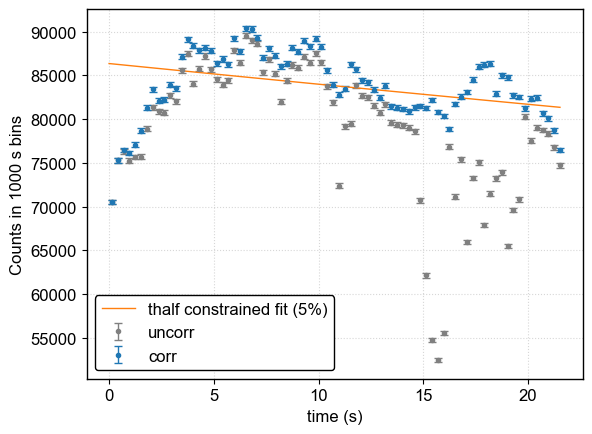

In [16]:
t_half_life = 9.92 * 24 * 3600 # updated value (2019) from NNDC for Ac-225
th = ts / 3600

thalf = t_half_life / 3600
p0 = [150000, thalf]

tol = 0.05
popt, pcov = curve_fit(f=po.exponential, xdata=th, ydata=corr_count, p0=p0,
                       bounds=([0, thalf * (1-tol)], [np.inf, thalf * (1 + tol)]))
xdummy = np.linspace(0, max(th))
plt.errorbar(th, count, np.sqrt(count), ls='none', capsize=3, marker='.', label='uncorr', color='gray')
plt.errorbar(th, corr_count, np.sqrt(count), ls='none', capsize=3, marker='.', label='corr')
plt.plot(xdummy, po.exponential(xdummy, *popt), label='thalf constrained fit (5%)')

popt, pcov = curve_fit(f=po.exponential, xdata=th, ydata=corr_count, p0=p0,
                      bounds=([0,np.inf]))

plt.xlabel('time (s)')
plt.ylabel('Counts in {} s bins'.format(time_binsize))

plt.legend()
plt.show()